# Assignment 2 Data modelling and presentation

This assignment focuses on data modelling, a core step in the data science process. You
will need to develop and implement appropriate steps, in IPython, to complete the corre-
sponding tasks.

This assignment is intended to give you practical experience with the typical 5th and 6th
steps of the data science process: data modelling, and presentation and automation.
The \Practical Data Science" Canvas contains further announcements and a discussion
board for this assignment. Please be sure to check these on a regular basis { it is your
responsibility to stay informed with regards to any announcements or changes. Login
through https://rmit.instructure.com/.

## Task one 1: Data retrieving

This assignment will focus on data modelling, and you can choose to focus on one approach:
Classifcation or Clustering.
For this assignment, you need to select one suitable dataset, from the following options:
1. Find and then analyse your own data set, in a domain that is of interest to you. If you choose this option, you will need to:
    * include a detailed description of the data in your report in Task 4, and describe each attribute of it, including the type, the range of possible values, whether it contains any missing values/errors
    * submit a copy of the dataset, to allow the assessment of your modelling result.



In [1]:
COMPLETE_RUN = False

### Install packages

In [2]:
#packages to install
# !pip install tqdm # this is visulise how long something takes
# !pip install numpy 
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
# !pip install scipy
# !pip install librosa 
# !pip install keras
# !pip install utils
# !pip install np_utils

### Load the packages

In [153]:
import numpy as np
np.random.seed(1001)

import os
import shutil
from tqdm import tqdm
import IPython
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import sklearn

import numpy as np
import scipy

import wave
from scipy.io import wavfile
from scipy import fftpack

import IPython.display as ipd  # To play sound in the notebook

import wave
from scipy.io import wavfile
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from librosa.feature import mfcc

from python_speech_features import mfcc
from python_speech_features import logfbank

%matplotlib inline
matplotlib.style.use('ggplot')

### Load the labelled information


In [142]:
fPath = "01_In/freesound-audio-tagging-2019/"
path = '01_In/freesound-audio-tagging-2019/train_curated/'
try:
    train = pd.read_csv(fPath + "train_curated.csv")
    test = pd.read_csv(fPath + "sample_submission.csv")
except IOError:
    print "Could not read file, please change file path"

# Task 2: Data exploration and processing

In [143]:
#look at the labels in the train set
train.head(15)

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
5,003be5db.wav,Whispering
6,0041de6b.wav,"Acoustic_guitar,Strum"
7,004ca909.wav,Hi-hat
8,00713ec2.wav,Bass_drum
9,0073825a.wav,"Crowd,Cheering"


In [144]:
#look at the number files in the training and test set as well as the number of classes
print("No. of train = " + str(train.shape[0]), "  No. of classes=", len(set(train.labels)))
print("No. of test = " + str(test.shape[0]), "  No. of classes=", len(set(test.columns[1:])))

#look at the minimum and maximum labels per category
print('Minimum samples = ' + str(min(train.labels.value_counts())) + ' Labels')
print('Maximum samples= ' + str(max(train.labels.value_counts())) + ' Labels')

('No. of train = 4970', '  No. of classes=', 213)
('No. of test = 1120', '  No. of classes=', 80)
Minimum samples = 1 Labels
Maximum samples= 75 Labels


Number of training labels in test columns: 4269
Number of training lables in the training set: 74


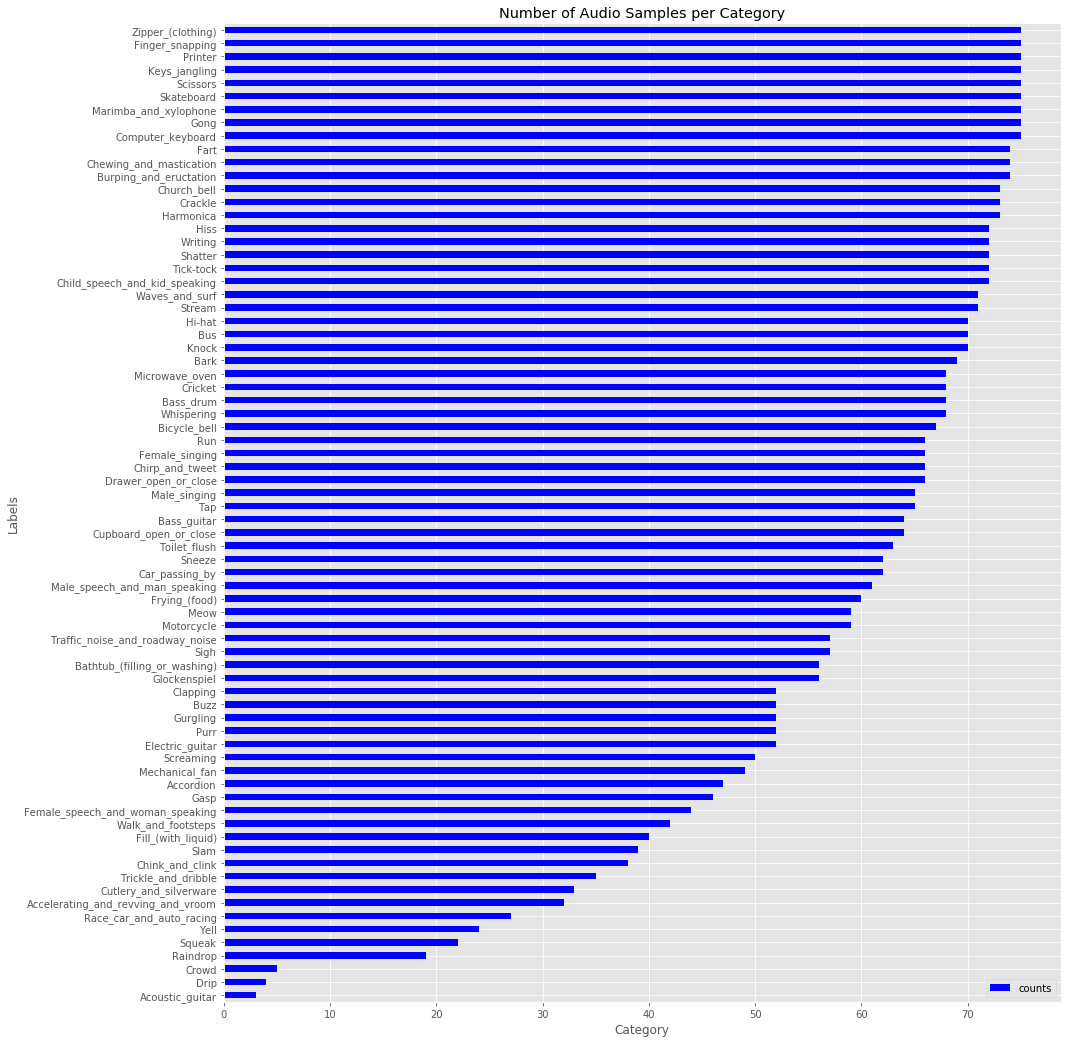

In [145]:
#look at how many train labels is in the test columns
train = train[train.labels.isin(test.columns[1:])]
print('Number of training labels in test columns: ' + str(len(train)))

#Count the type of labels by their group
category = train.groupby(['labels']).count()
category.columns = ['counts']
print('Number of training lables in the training set: ' + str(len(category)))

#plot the number of samples per category
plot = category.sort_values(ascending=True, by='counts').plot(
    kind='barh', 
    title="Number of Audio Samples per Category", 
    color='blue', 
    figsize=(15,18))
plot.set_xlabel("Category")
plot.set_ylabel("Labels");

### Find the distribution of the data by looking at the length
The varying length of audio will cause issues when applying the classfication model. If there is a class imbalance, this will cause issues int he modelling phase

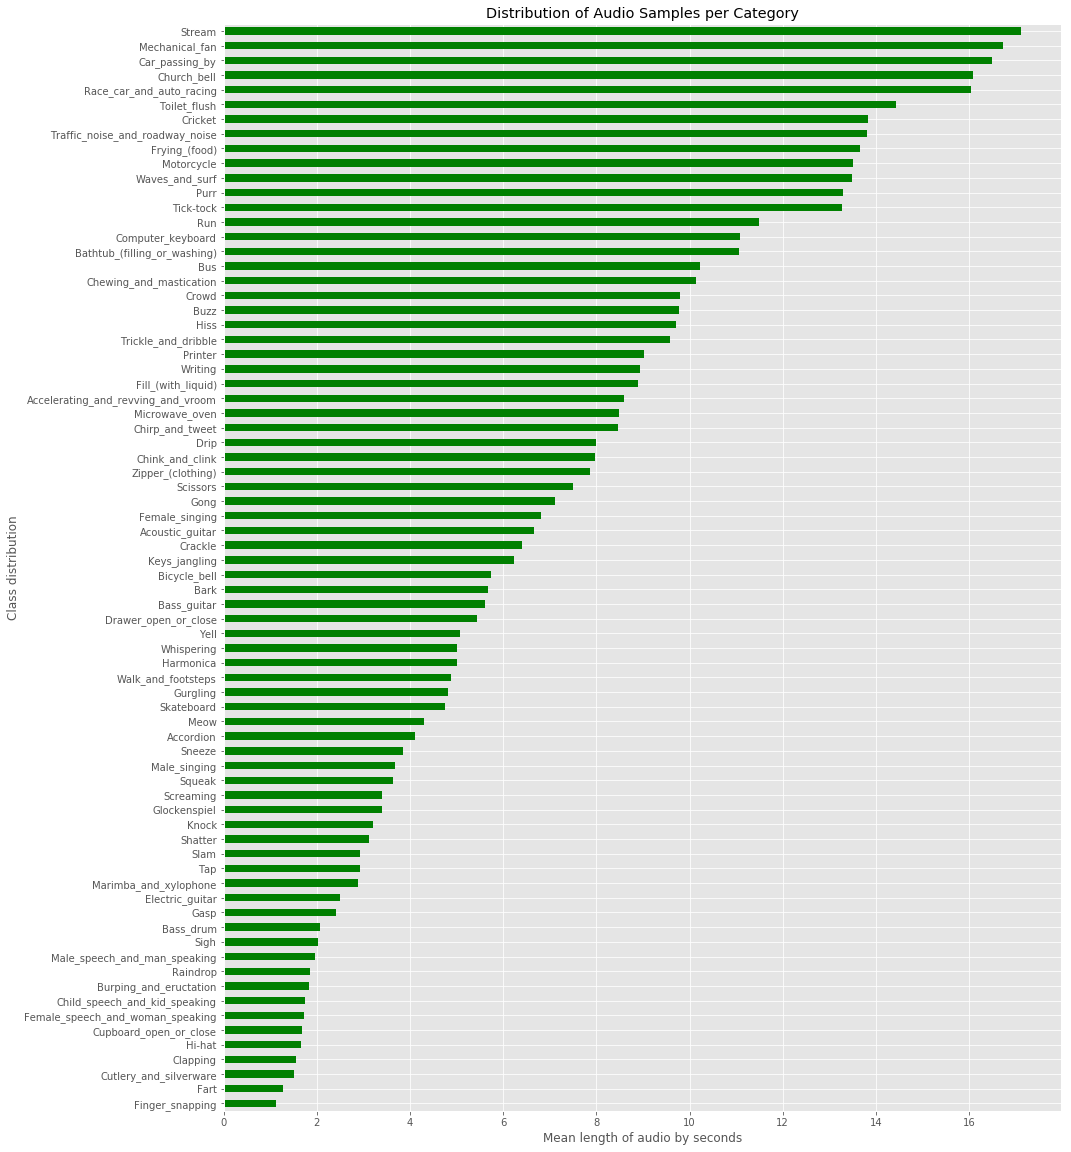

In [146]:
#this will take a few minutes
train.set_index('fname', inplace = True) #set index

#loop through the train data set to get the length of all the audio
for f in train.index: #to hold filename column
    rate, signal = wavfile.read(fPath + 'train_curated/' + f) #read in the individual files
    train.at[f, 'length'] = signal.shape[0]/rate #positional base index by using at, create column called length (sec) - read signal length of signal/sampling rate
train.head(5)

#create class distribution
classes = list(np.unique(train.labels)) #get unique lables

#get a class distribution
class_distribution = train.groupby(['labels'])['length'].mean() #group label and of the group you want access to just the length of all the values

#visualise the distribution of the audio classes
plot = class_distribution.sort_values(ascending=True).plot(
    kind='barh', 
    title="Distribution of Audio Samples per Category", 
    color='green', 
    figsize=(15,20))
plot.set_xlabel("Mean length of audio by seconds")
plot.set_ylabel("Class distribution");

train.reset_index(inplace = True)

### Look at the sample frame rate for the data

In [147]:
#return dataframe with values [index, column] gives 1 sample for each class
for c in classes:
    wav_file = train[train.labels == c].iloc[0,0] #return dataframe with values [index, column] gives 1 sample for saxaphone etc
    #look at sampling frame rate, and number of frames
#     rate, data = wavfile.read('01_In/freesound-audio-tagging-2019/train_curated/' + wav_file)
#     print("Sampling (frame) rate = ", rate)
#     print("Total samples (frames) = ", data.shape)
#     print(data)    
    fs, wave = scipy.io.wavfile.read(fPath +'train_curated/' + wav_file) 
    print 'file: ', wav_file
    print 'Data:', wave
    print 'Sampling rate:', fs
    print 'Audio length:', wave.size/fs, 'seconds'
    print 'Lowest amplitude:', min(wave)
    print 'Highest amplitude:', max(wave)

file:  0199c0a0.wav
Data: [  775   707   692 ... -3847 -3882 -3979]
Sampling rate: 44100
Audio length: 2 seconds
Lowest amplitude: -15586
Highest amplitude: 18101
file:  02171503.wav
Data: [ -26  -33  -31 ... 2703 2835 2502]
Sampling rate: 44100
Audio length: 1 seconds
Lowest amplitude: -21861
Highest amplitude: 29198
file:  2883b626.wav
Data: [ 0 -1  0 ...  0  0  0]
Sampling rate: 44100
Audio length: 8 seconds
Lowest amplitude: -12624
Highest amplitude: 11807
file:  0006ae4e.wav
Data: [0 0 0 ... 0 1 2]
Sampling rate: 44100
Audio length: 7 seconds
Lowest amplitude: -2891
Highest amplitude: 3593
file:  00713ec2.wav
Data: [-585 3110 4315 ...    0    0    0]
Sampling rate: 44100
Audio length: 0 seconds
Lowest amplitude: -32392
Highest amplitude: 32432
file:  00c17dd2.wav
Data: [    0     0     0 ... -4788 -4461 -4105]
Sampling rate: 44100
Audio length: 9 seconds
Lowest amplitude: -32496
Highest amplitude: 32480
file:  10e735ff.wav
Data: [647 798 716 ...  35 209 424]
Sampling rate: 44100
A

Sampling rate: 44100
Audio length: 1 seconds
Lowest amplitude: -9471
Highest amplitude: 9903
file:  0569539d.wav
Data: [-249 -252 -249 ...    0    0   -2]
Sampling rate: 44100
Audio length: 3 seconds
Lowest amplitude: -27727
Highest amplitude: 22446
file:  013b01b9.wav
Data: [ 8 47 28 ... 86 80 59]
Sampling rate: 44100
Audio length: 4 seconds
Lowest amplitude: -9592
Highest amplitude: 11607
file:  055a129d.wav
Data: [-44 -38 -33 ...  -5 -12  -7]
Sampling rate: 44100
Audio length: 5 seconds
Lowest amplitude: -32706
Highest amplitude: 32767
file:  03f48534.wav
Data: [347 352 363 ... 276 273 270]
Sampling rate: 44100
Audio length: 5 seconds
Lowest amplitude: -18584
Highest amplitude: 16023
file:  06aa0e9b.wav
Data: [ 0  0  0 ... -1  0  0]
Sampling rate: 44100
Audio length: 3 seconds
Lowest amplitude: -32768
Highest amplitude: 32767
file:  04763f39.wav
Data: [  28   42   42 ... -114  -85 -100]
Sampling rate: 44100
Audio length: 1 seconds
Lowest amplitude: -8016
Highest amplitude: 7473
file

### Remove audio where the length is less than 1sec
There are 4269 samples in total. 
There are 674 rows with length of 0 seconds
After removing audio with 0 sec length left with 3595



In [148]:
zeroLength = train.loc[train['length'] == 0]
cTrain = train.loc[train['length'] > 0]

### Create function for calculate fft

In [149]:
# y is the signal
#inverse rate 1/rate is the time pass between samples
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    #magnitude of complex number - you need the abs value and takes sum of squares, divide by n to normalise it
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq) 

### Create functions to visualise the data

In [150]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16, y = 1.08)
    i = 0
    for x in range(5):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16, y = 1.08)
    i = 0
    for x in range(5):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16, y = 1.08)
    i = 0
    for x in range(5):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


### Create a function to get rid of dead space in the audio
This is known as the envelope. Noise threshold detection, check values are below what the microphone can detect. Computation to get rid of deadspace in audio.

In [151]:
#calculate envelope of a signal to get rid of the dead space
def envelope(y, rate, threshold):
    #reduce and remove empty part of the data
    mask = []
    #create a series to pass signal y, use series so that you can us apply. the signal can be negative so just want to calculate absolute value
    y = pd.Series(y).apply(np.abs)
    '''to get absolute value, need to rolling. 
    basically rolls over the data and find the mean to see if the entre signal has dropped out
    as it crosses x axis regularly and if 1 value is picked, and you get rid of it, the data will be ruined
    rate is 1/10 of a sec and pass the min_period (minimum value for calculation), min period will stop it 
    from returning nan'''
    y_mean = y.rolling(window = int(rate/10), min_periods =1, center = True).mean()
    #agrgreated mean has been created. So look for the mean that is greater than threshold. 
    for mean in y_mean:
        if mean > threshold: 
            mask.append(True)
        else:
            mask.append(False)
    return mask

### Look at the data in plots
For each class, we want to investigate and look at each plots to see if the data needs processing. 

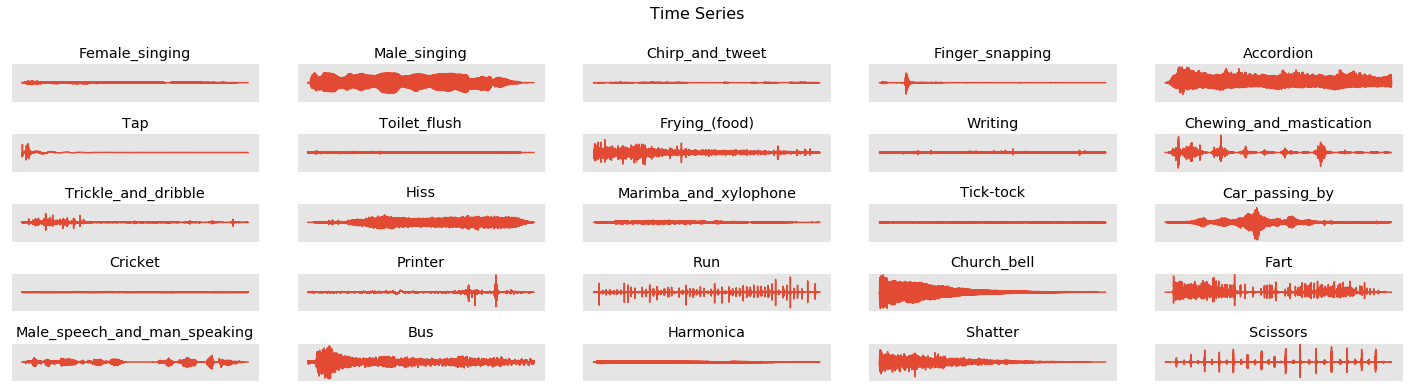

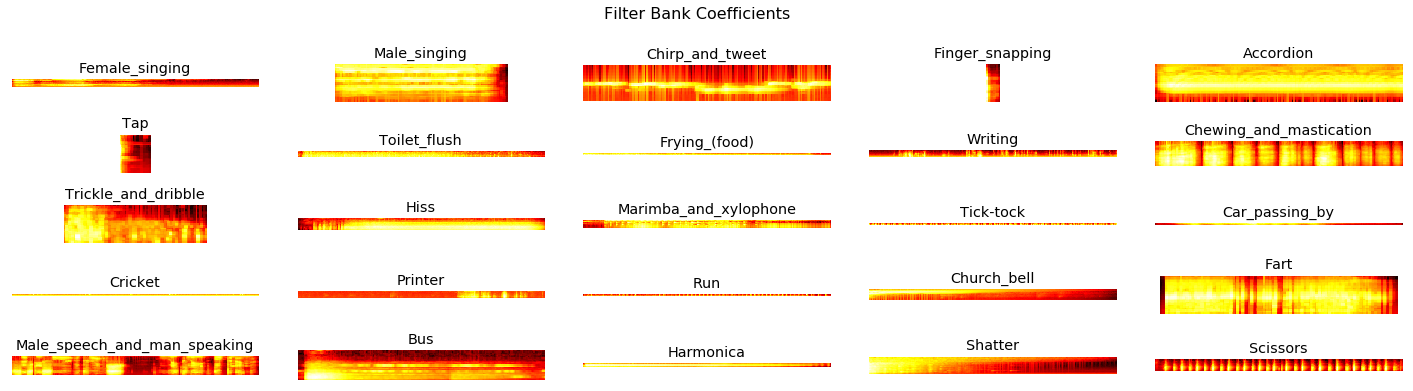

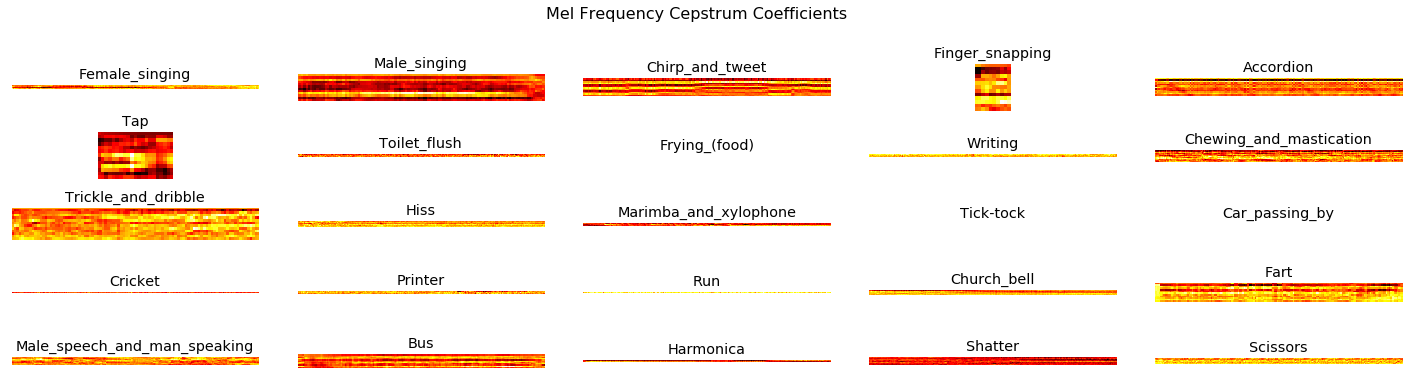

In [155]:
#set up dictionaries to store the examples in the classes

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = cTrain[cTrain.labels ==c].iloc[0,0]
    signal, rate = librosa.load(path +wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    
    signals[c] = signal
    
    #nfft window 25 millisec, need to know need to know window length 44100/40 = 1103, take transpose
    bank = logfbank(signal, rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    
    #num ceptrals after doing discrete cosine after filter bank - typically throw out half
    mel = mfcc(signal, rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
plot_signals(signals)
plt.tight_layout()
plt.show()

plot_fbank(fbank)
plt.tight_layout()
plt.show()

plot_mfccs(mfccs)
plt.tight_layout()
plt.show()
    
    

### Create folder of the audio samples that are clean to be put in the model

** DO NOT RUN ** this output in the clean set gave terrible results so this was abandoned

In [15]:
# #iterate through the dataset and downsample the audios for input into the model. 

# #check if the folder is empty
# if len(os.listdir('02_Out/clean_train')) == 0:
#     #tqdm is so we can track where the file creation is up to
#     for f in tqdm(cTrain.fname):
#         #read in the wav file and downsample to 16000 using librosa
#         signal, rate = librosa.load(path +f, sr = 16000)
#         #use the envelope function to 
#         mask = envelope(signal, rate, 0.005)
#         #change the location if reruning the code
#         wavfile.write(filename = '02_Out/clean_train/'+f, rate = rate, data = signal[mask])

# Feature Engineering

In [125]:
# Prepare features: 130 from MFCC of smallest wave and min, max and average of the rest of data
df = np.zeros((len(train),133))
c = 0

for i in train["fname"]:
    (rate, sig) = wavfile.read(path + i)
    sig = sig.astype("float")
    mfcc_feat = mfcc(sig[:13229],rate,n_mfcc=5)
    mfcc_data = mfcc_feat.reshape(-1,130)
    df[c][:130] = mfcc_data
    df[c][130] = np.min(sig[13229:])
    df[c][131] = np.max(sig[13229:])
    df[c][132] = np.mean(sig[13229:])
    c = c+1

In [126]:
df = pd.DataFrame(df)
df.shape

(4269, 133)

In [127]:
# Standardise the features
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

In [130]:
# Principal Component Analysis to half the number of features
pca = PCA(n_components=68)
pca.fit(scaled_df)
principalComponents = pca.transform(scaled_df)

In [131]:
# Cumulative explained variance ratio
exp_variance = np.array([pca.explained_variance_ratio_[:i].sum() for i in range(1, 69)])

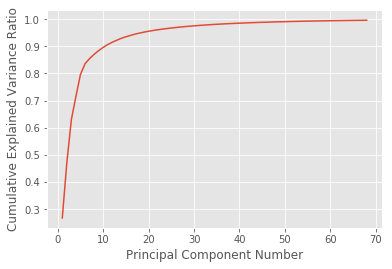

In [132]:
plt.plot(range(1,69),exp_variance)
plt.ticklabel_format(style='plain')
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xlabel("Principal Component Number")
plt.show()

In [133]:
print("Number of components that explain 99% variance in the data =",sum(exp_variance<0.99))

('Number of components that explain 99% variance in the data =', 47)


In [134]:
# Prepare Principal Component DataFrame
principalDf = pd.DataFrame(data = principalComponents)
principalDf = principalDf.iloc[:,:48]
principalDf

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2.209754,-1.928396,4.957369,-0.918711,-2.381256,-1.704119,1.827272,0.779584,0.660531,2.490273,...,0.051405,-0.072720,-0.406255,-0.185328,0.021341,0.124991,-0.063264,0.078450,0.052129,0.036919
1,3.277224,-0.244608,-3.879858,0.003068,-0.769050,-1.552754,4.862956,1.725249,1.311995,1.843157,...,-0.470625,0.190088,0.293122,0.284881,0.258184,0.161537,0.445619,-0.431930,0.271914,-0.039561
2,2.536486,4.114843,0.283990,1.729662,1.993289,4.834786,0.053026,0.205935,-0.111543,1.685111,...,0.118764,0.307752,-0.404739,-0.194711,-0.010455,0.096227,0.255103,-0.208166,-0.003459,-0.100275
3,3.972858,0.034783,-1.453636,0.790216,-1.110946,-0.606040,0.248981,0.143895,-1.714629,-0.658491,...,-0.242301,0.075082,0.232044,0.103253,-0.191678,0.288938,0.103745,-0.071865,0.035462,0.034866
4,18.338934,17.305992,3.851635,-11.396985,0.663189,-0.265190,0.033039,-0.113514,-1.793222,-1.768757,...,-0.047338,0.132196,-0.047883,0.076803,0.024516,-0.013012,0.021488,-0.007606,0.021453,0.055266
5,18.337258,17.302162,3.851393,-11.399800,0.661106,-0.282569,0.024336,-0.096266,-1.859853,-1.818141,...,-0.045264,0.132742,-0.044385,0.085358,0.023345,-0.011740,0.019759,-0.007498,0.023299,0.050726
6,-2.119754,8.859162,-2.333931,6.965517,1.890942,-1.643292,0.109553,-1.506070,2.140366,0.110218,...,0.032062,0.347147,0.075289,0.425359,0.120590,0.002927,0.122161,-0.016748,0.158627,0.000854
7,5.986368,-7.043867,-1.450210,3.257269,-0.968153,3.242308,0.406293,-2.074290,0.150537,1.149766,...,0.160831,0.113732,-0.368989,-0.058673,-0.104538,0.168717,0.053498,-0.147113,-0.100538,0.186274
8,-6.026527,3.882554,-5.637802,3.320024,-0.400165,-0.240010,1.441946,1.239032,-1.510195,0.469107,...,-0.058711,0.234937,0.193516,0.038632,-0.169439,-0.284608,-0.106354,-0.048249,0.222878,-0.122488
9,-4.873881,5.875911,-3.693248,4.229315,-1.286257,-1.196522,0.075239,1.012555,-1.592897,-1.397264,...,-0.189475,0.157900,-0.230016,0.058737,0.118697,-0.170616,0.109012,0.701605,-0.326646,-0.775470


In [137]:
# Prepare Target Variable
labels = [None]*len(train)
c=0

for i in train["labels"]:
    labels[c] = i
    c = c+1
len(labels)

4269

# Task 3 Model Building and Evaluation

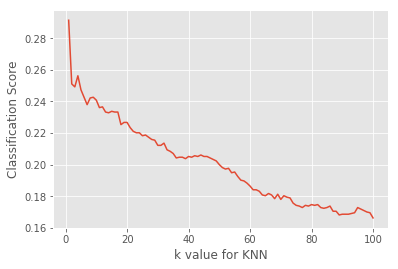

C:\Users\Consultant\.conda\envs\audio\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.10      0.11      0.10        19
                         Accordion       0.55      0.78      0.64        23
                   Acoustic_guitar       0.00      0.00      0.00         2
                              Bark       0.83      0.57      0.68        35
                         Bass_drum       0.85      0.72      0.78        40
                       Bass_guitar       0.82      0.84      0.83        32
      Bathtub_(filling_or_washing)       0.05      0.04      0.04        24
                      Bicycle_bell       0.57      0.41      0.47        32
            Burping_and_eructation       0.21      0.12      0.15        41
                               Bus       0.38      0.56      0.45        36
                              Buzz       0.09      0.23      0.13        22
                    Car_passing_by       0.31      0.61      0.41        28
           

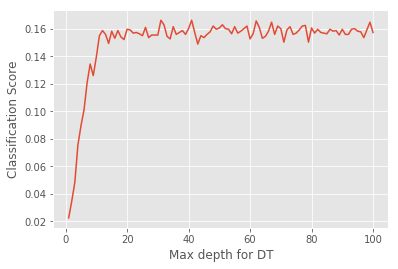

C:\Users\Consultant\.conda\envs\audio\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.00      0.00      0.00        19
                         Accordion       0.18      0.26      0.21        23
                   Acoustic_guitar       0.00      0.00      0.00         2
                              Bark       0.52      0.43      0.47        35
                         Bass_drum       0.58      0.38      0.45        40
                       Bass_guitar       0.62      0.75      0.68        32
      Bathtub_(filling_or_washing)       0.04      0.04      0.04        24
                      Bicycle_bell       0.13      0.16      0.14        32
            Burping_and_eructation       0.06      0.02      0.03        41
                               Bus       0.44      0.31      0.36        36
                              Buzz       0.06      0.09      0.07        22
                    Car_passing_by       0.23      0.39      0.29        28
           

In [138]:
from sklearn.metrics import classification_report
from sklearn import tree
# 50% Test split
X_train, X_test, y_train, y_test = train_test_split(principalDf,labels,test_size=0.50,random_state=4)
score = pd.DataFrame()

#KNN

for i in range(1,101):
    clf = knn(i)
    clf.fit(X_train, y_train)
    score.at[i-1,"n"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["n"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("k value for KNN")
plt.show()
n = score[score["score"]==np.max(score["score"])].n
n = n.values[0].astype("int")
clf = knn(n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))

score = pd.DataFrame()

# DT

for i in range(1,101):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    score.at[i-1,"max_depth"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["max_depth"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("Max depth for DT")
plt.show()
n = score[score["score"]==np.max(score["score"])].max_depth
n = n.values[0].astype("int")
clf = tree.DecisionTreeClassifier(max_depth=n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))

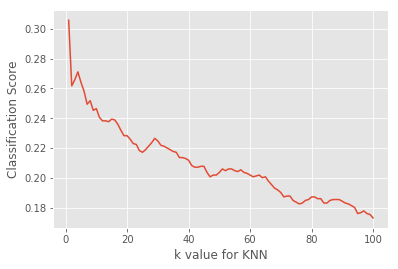

                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.07      0.07      0.07        15
                         Accordion       0.54      0.79      0.64        19
                   Acoustic_guitar       0.00      0.00      0.00         2
                              Bark       0.78      0.54      0.64        26
                         Bass_drum       0.80      0.83      0.81        29
                       Bass_guitar       0.81      0.81      0.81        27
      Bathtub_(filling_or_washing)       0.06      0.05      0.05        19
                      Bicycle_bell       0.60      0.41      0.49        29
            Burping_and_eructation       0.17      0.14      0.15        29
                               Bus       0.36      0.53      0.43        30
                              Buzz       0.07      0.15      0.10        20
                    Car_passing_by       0.35      0.62      0.45        24
           

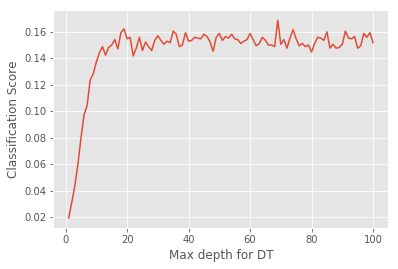

                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.00      0.00      0.00        15
                         Accordion       0.30      0.32      0.31        19
                   Acoustic_guitar       0.00      0.00      0.00         2
                              Bark       0.44      0.31      0.36        26
                         Bass_drum       0.50      0.48      0.49        29
                       Bass_guitar       0.82      0.52      0.64        27
      Bathtub_(filling_or_washing)       0.00      0.00      0.00        19
                      Bicycle_bell       0.23      0.28      0.25        29
            Burping_and_eructation       0.06      0.07      0.07        29
                               Bus       0.37      0.23      0.29        30
                              Buzz       0.00      0.00      0.00        20
                    Car_passing_by       0.28      0.46      0.35        24
           

In [139]:
# 40% Test split
X_train, X_test, y_train, y_test = train_test_split(principalDf,labels,test_size=0.40,random_state=4)
score = pd.DataFrame()

#KNN

for i in range(1,101):
    clf = knn(i)
    clf.fit(X_train, y_train)
    score.at[i-1,"n"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["n"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("k value for KNN")
plt.show()
n = score[score["score"]==np.max(score["score"])].n
n = n.values[0].astype("int")
clf = knn(n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))

score = pd.DataFrame()

# DT

for i in range(1,101):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    score.at[i-1,"max_depth"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["max_depth"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("Max depth for DT")
plt.show()
n = score[score["score"]==np.max(score["score"])].max_depth
n = n.values[0].astype("int")
clf = tree.DecisionTreeClassifier(max_depth=n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))

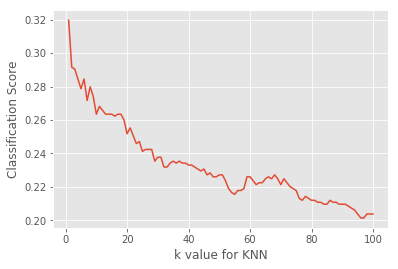

                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.12      0.10      0.11        10
                         Accordion       0.40      0.67      0.50         9
                   Acoustic_guitar       0.00      0.00      0.00         1
                              Bark       0.80      0.62      0.70        13
                         Bass_drum       0.86      0.67      0.75        18
                       Bass_guitar       0.70      0.78      0.74         9
      Bathtub_(filling_or_washing)       0.00      0.00      0.00         6
                      Bicycle_bell       0.64      0.60      0.62        15
            Burping_and_eructation       0.20      0.19      0.19        16
                               Bus       0.45      0.62      0.53        16
                              Buzz       0.13      0.18      0.15        11
                    Car_passing_by       0.29      0.45      0.36        11
           

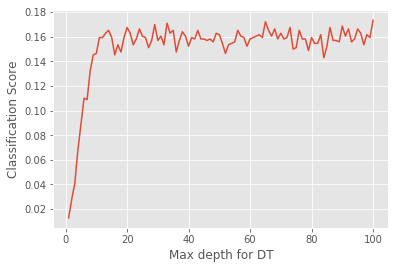

                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.00      0.00      0.00        10
                         Accordion       0.45      0.56      0.50         9
                   Acoustic_guitar       0.00      0.00      0.00         1
                              Bark       0.60      0.46      0.52        13
                         Bass_drum       0.50      0.28      0.36        18
                       Bass_guitar       0.33      0.22      0.27         9
      Bathtub_(filling_or_washing)       0.00      0.00      0.00         6
                      Bicycle_bell       0.24      0.27      0.25        15
            Burping_and_eructation       0.07      0.06      0.06        16
                               Bus       0.35      0.38      0.36        16
                              Buzz       0.07      0.09      0.08        11
                    Car_passing_by       0.09      0.09      0.09        11
           

In [140]:
# 20% Test split
X_train, X_test, y_train, y_test = train_test_split(principalDf,labels,test_size=0.20,random_state=4)
score = pd.DataFrame()

# KNN

for i in range(1,101):
    clf = knn(i)
    clf.fit(X_train, y_train)
    score.at[i-1,"n"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["n"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("k value for KNN")
plt.show()
n = score[score["score"]==np.max(score["score"])].n
n = n.values[0].astype("int")
clf = knn(n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))

score = pd.DataFrame()

#DT

for i in range(1,101):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    score.at[i-1,"max_depth"] = i
    score.at[i-1,"score"] = clf.score(X_test,y_test)
plt.plot(score["max_depth"],score["score"])
plt.ylabel("Classification Score")
plt.xlabel("Max depth for DT")
plt.show()
n = score[score["score"]==np.max(score["score"])].max_depth
n = n.values[0].astype("int")
clf = tree.DecisionTreeClassifier(max_depth=n)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(classification_report(y_test,predict))